# Overview
this notebook is an implementation of the PSO approach to eliminate multicollinearily in any given dataset.

In [29]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
def display_heat_map(data: pd.DataFrame, title: str):
    plt.figure(figsize=(10,10))
    sns.heatmap(data, linewidth = 1 , annot = True)
    plt.title(title)
    plt.show()

In [31]:
from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sko.PSO import PSO
from math import floor
from sklearn.decomposition import PCA


class PsoMultiCol:
    def set_data(self, df):
        self.df = df
        # calculate the spearmanr correlation of the dataframe's features
        corr = spearmanr(df).correlation
        # make sure it is symmetric
        corr = (corr + corr.T) / 2
        # fill the diagonal with 1s
        np.fill_diagonal(corr, 1)
        # transform the matrix to a dataframe that represents how similar each feature it is to another
        self.dis_matrix = pd.DataFrame(data= (1 - np.abs (corr)), columns=list(df.columns), index=list(df.columns))
        # have a dictionary mapping the column's order to its name
        self.columns_dict = dict(list(zip(range(len(df.columns)), df.columns)))
        # set the number of features for later reference
        self.num_feats = len(df.columns)
        # save the column names for later reference
        self.columns = list(df.columns)
       
    def __init__ (self, df:pd.DataFrame=None, max_iter:int= 200, vif_threshold:float=2.5, epsilon:int=0.1,
                  min_fraction=0.25, max_fraction=0.76, step=0.05): # add other parameters to the game
        self.max_iter = max_iter
        self.pso = None
        # the value that determine whether columns are multicollinear or not
        self.vif_threshold = vif_threshold
        # an epsilon value used in the evaluation function
        self.epsilon = epsilon
        self.min_fraction = min_fraction
        self.max_fraction = max_fraction
        self.step = step
        self.pso = None
        if df is not None:
            self.set_data(df)
    
    def _get_vif(self, df=None):
        if df is None:
            df = self.df
        
        vif = pd.DataFrame()
        vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
        vif['variables'] = df.columns
        return vif.set_index('variables')   
    

    def _get_clusters(self, particle: np.array):
        particle_size = len(particle)
        discrete_particle = np.array([int(x) for x in particle])
        cluster_feats = {}
        for i in range(particle_size) :
            # if the value of the cluster is not in the dictinary, initialize the list
            if discrete_particle[i] not in cluster_feats:
                cluster_feats[discrete_particle[i]] = []
            # the cluster_feats will be a map between numbers representing clusters
            # and columns representing 
            cluster_feats[discrete_particle[i]].append(i)
        
        return cluster_feats    
    
    
    def _cluster_scores(self, cluster_feats: dict):
        score = 0
        # let's concatenate the the clusters together and visualize the effect of the clustering
        new_order = []
        title  = ""
        # for each cluster
        for _, feats in cluster_feats.items():
            cluster_names = [self.columns_dict[i] for i in feats]
            no_cluster_names = [n for n in self.columns if n not in cluster_names]
            # how similar the features in the same cluster to one another
            inner_score = np.nanmean((self.dis_matrix.loc[cluster_names, cluster_names] ** 2) / 2) 
            # how dissimilar the features in the cluster to the features outside the cluster
            # a cluster with all elements should be penalized: with a outer_score = 0 (reflecs with a large value in the final score)
            outer_score = np.nanmean((self.dis_matrix.loc[cluster_names, no_cluster_names] ** 2) / 2) if no_cluster_names else 0  
            # a good cluster should have a low inner_score and a high outer score
            # a good cluster should have low score in general as PSO solves a minimization problem            
            score += (1 / (self.epsilon + outer_score) + (1 / self.epsilon) ** inner_score) / 2     
            
            new_order.extend(feats)
            title += f"{len(feats)}-"
        
        # return the sum of these score divided by the number of clusters
        return score / len(cluster_feats) 
    
    
    def _pso_function(self, particle: np.array):         
        return self._cluster_scores(self._get_clusters(particle))
    
    def _cluster_pso(self, num_clusters):
        # determine the function object to pass to the PSO algorithm
        pso_function = lambda x: self._pso_function(x)
        # bounds
        lower_bound = np.zeros(self.num_feats)
        upper_bound = np.full(shape=self.num_feats, fill_value = num_clusters, dtype="float")
        
        pso =  PSO(func=pso_function, n_dim = self.num_feats, pop=15, max_iter=self.max_iter ,lb=lower_bound, ub=upper_bound, c1=1.2, c2=1.2)
        pso.run()
        
        x, y = pso.gbest_x, pso.gbest_y
        
        cluster_feats = self._get_clusters(x)
        
        new_order = [] 
        title = ""
        for _, f in cluster_feats.items():
            new_order.extend(f)
            title += f'{len(f)}-'
        
        new_dist_matrix = self.dis_matrix.loc[new_order[::-1], new_order]
        display_heat_map(new_dist_matrix, title)
        
        return pso.gbest_x, pso.gbest_y
    
    def _find_best_cluster(self):
        best_score = np.inf
        best_x = None    
        for fraction in np.arange(self.min_fraction, self.max_fraction, self.step):
            num_clusters = floor(fraction  * self.num_feats)
            x, y = self._cluster_pso(num_clusters)
            if y < best_score:
                best_score = y
                best_x = x
        
        return best_x
    
    def _get_new_df(self, best_particle):
        # define a PCA object to combine the clustered 
        pca = PCA(n_components=1)

        # get the clusters out of the particle
        clusters = self._get_clusters(best_particle)
        # get the cluster
        new_dfs = []
        
        for _, feats in clusters.items():
            # reduce the clusted features into a single more informative feature
            new_feats = pd.DataFrame(data=pca.fit_transform(self.df.loc[:, feats]), index=list(self.df.index))
            new_dfs.append(new_feats)
        
        # return the features concatenated horizontally 
        return pd.concat(new_dfs, axis=1, ignore_index=True)
                        
        
    def eliminate_multicol(self, df: pd.DataFrame):
        # first of all determine the vifs of the different columns
        vif = self._get_vif(df)
        # retrieve multicollinear variables
        collinear = list(vif[vif['VIF'] >= self.vif_threshold].index)
        collinear_df = df.loc[:, collinear]

        # retrieve the non-collinear part
        non_collinear = [c for c in df.columns if c not in collinear]
        non_collinear_df = df.loc[:, non_collinear]
        
        # if there are no collinear columns, no further preprocessing is needed
        if not collinear:
            return df
        
        # set the df field to the fraction of the dataframe with only multicollinear columns
        self.set_data(collinear_df)
        # retrieve the best particle
        best_x = self._find_best_cluster()
        # retrive the new representation of the collinear features
        new_collinear_df = self._get_new_df(best_x)
        # concatenate the two parts to form the final dataframe
        return pd.concat([non_collinear_df, new_collinear_df], axis=1)

   

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


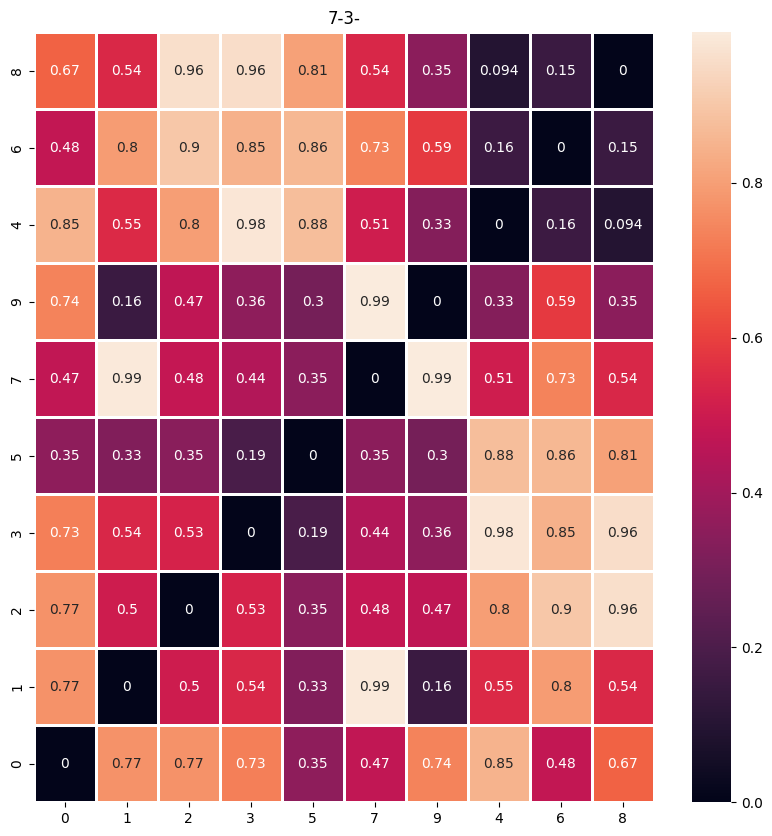

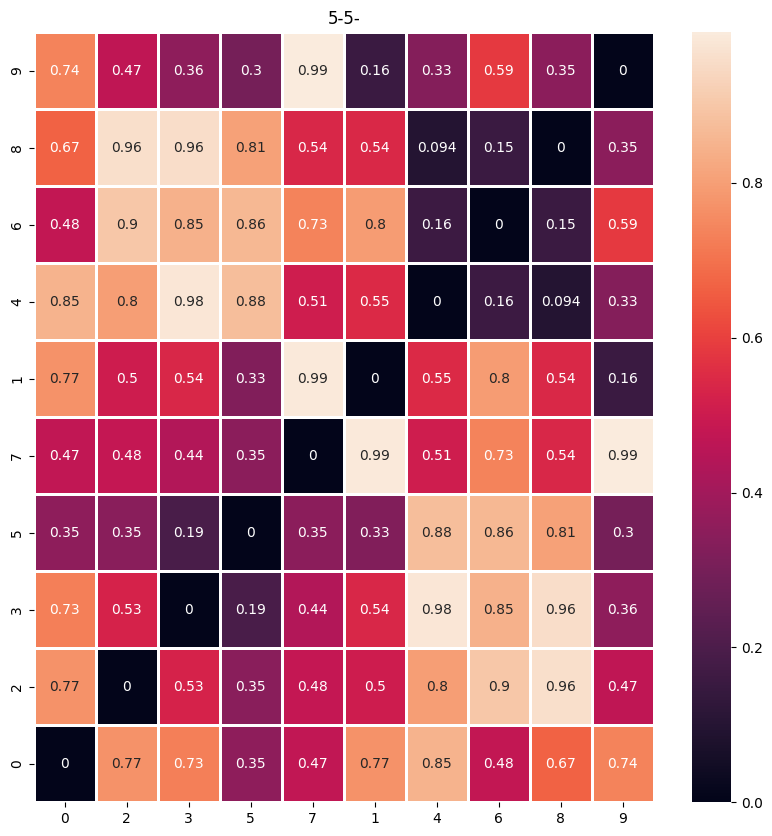

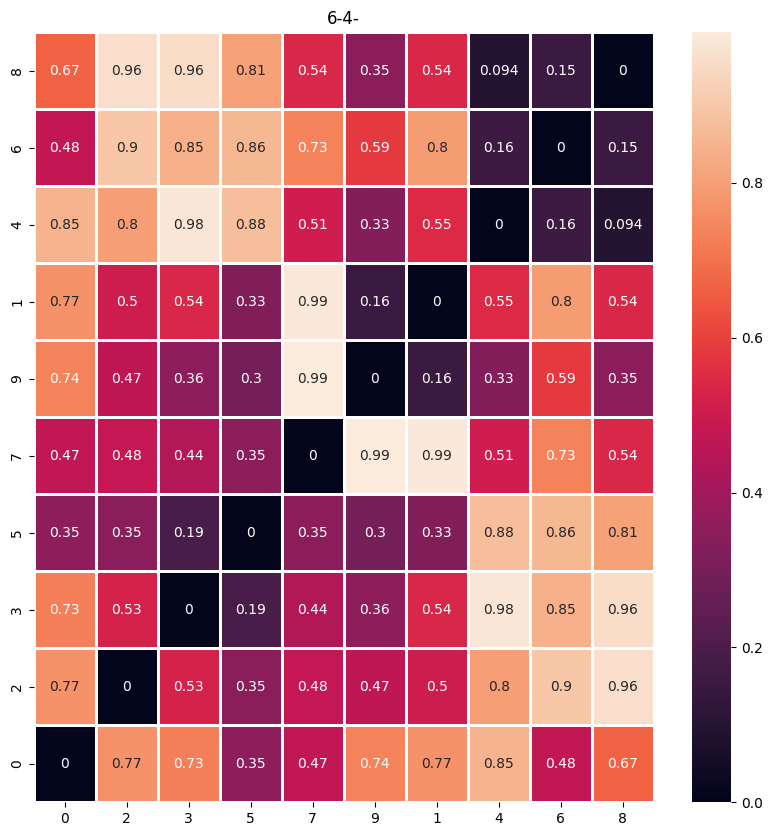

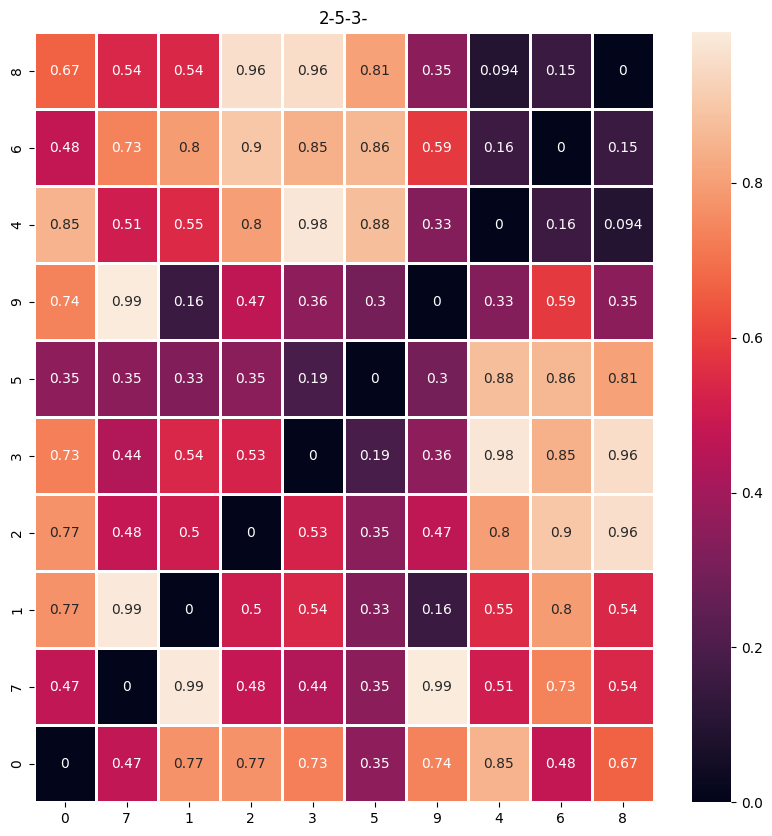

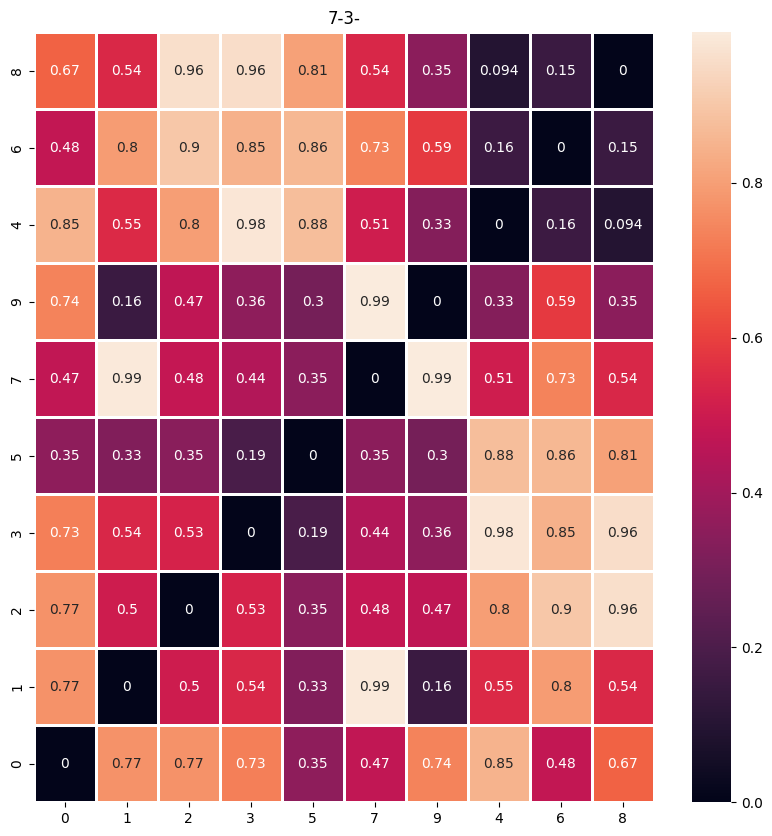

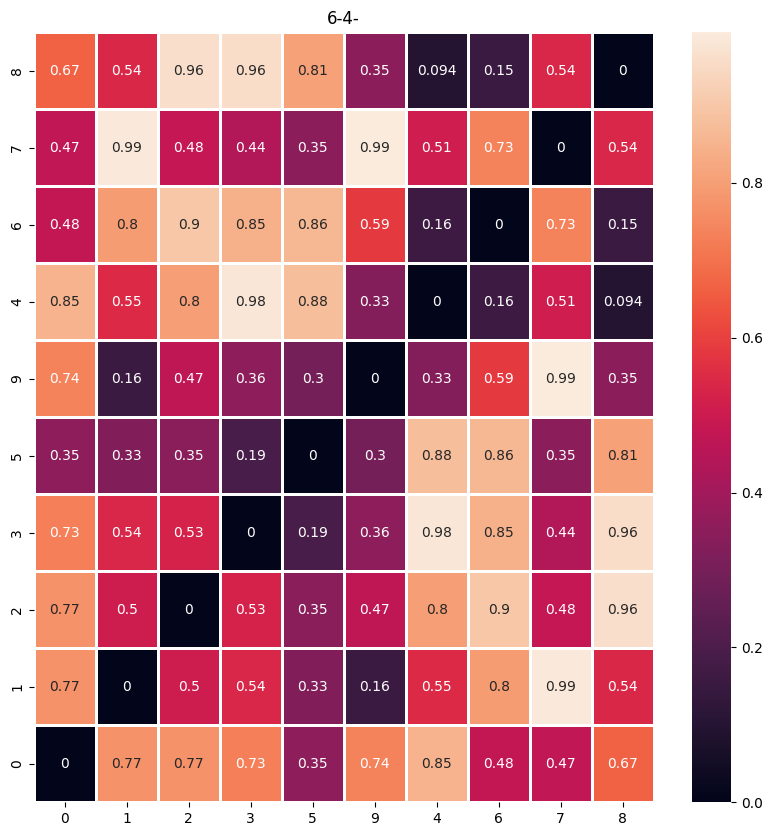

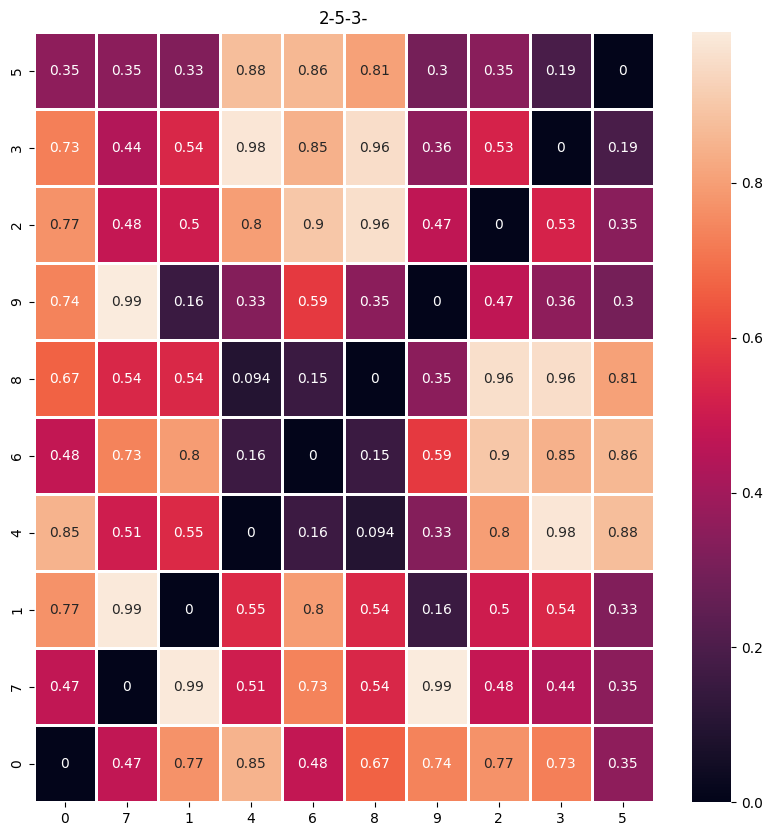

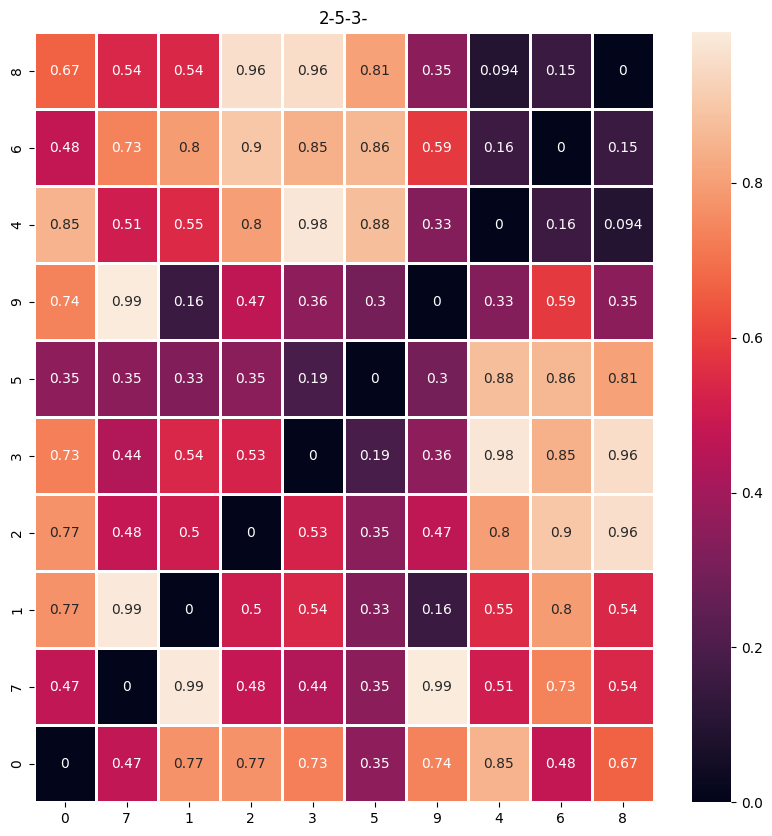

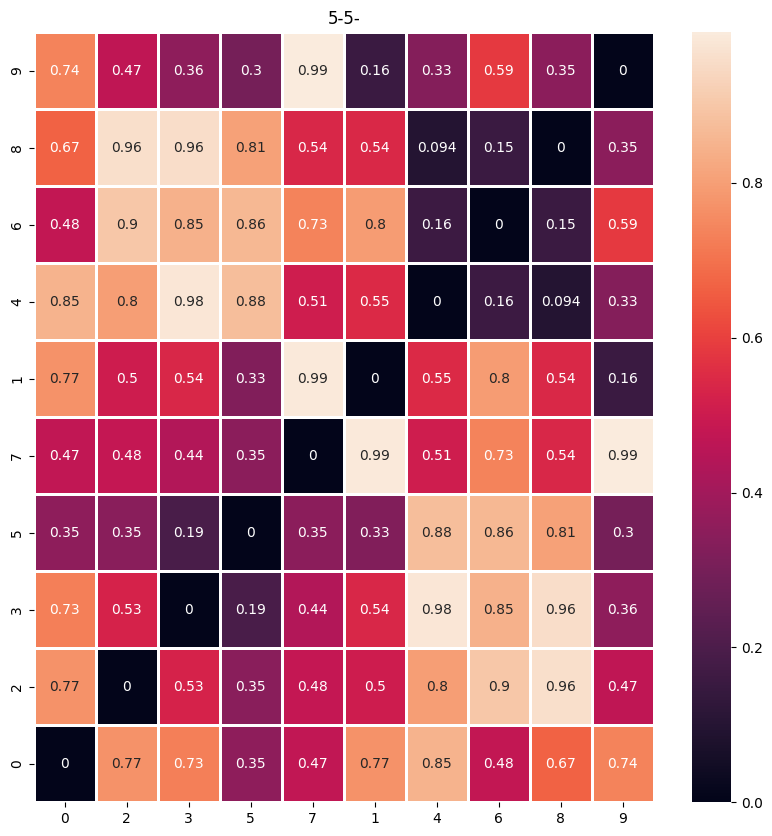

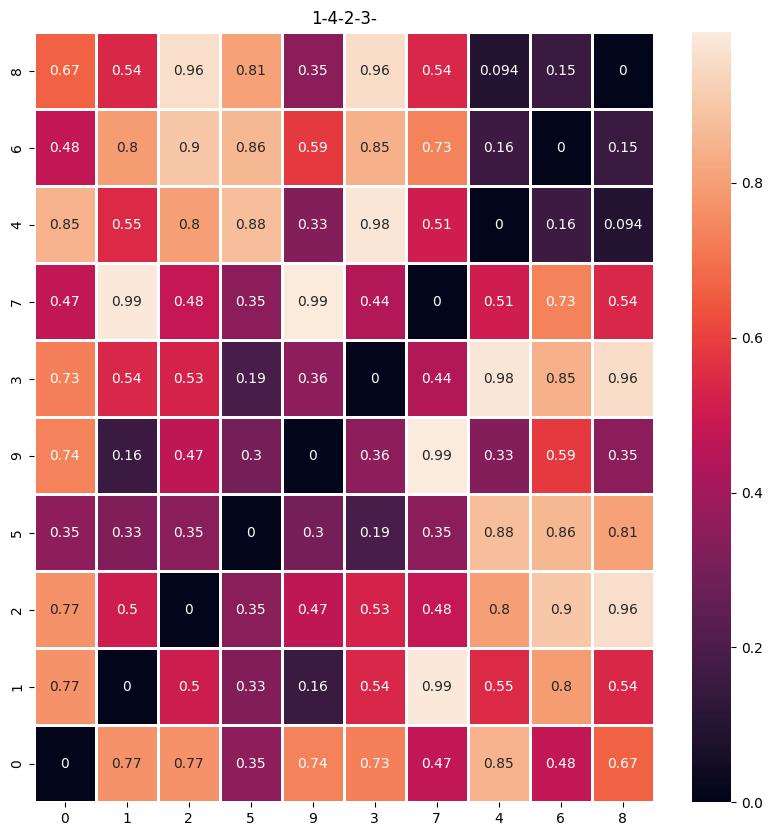

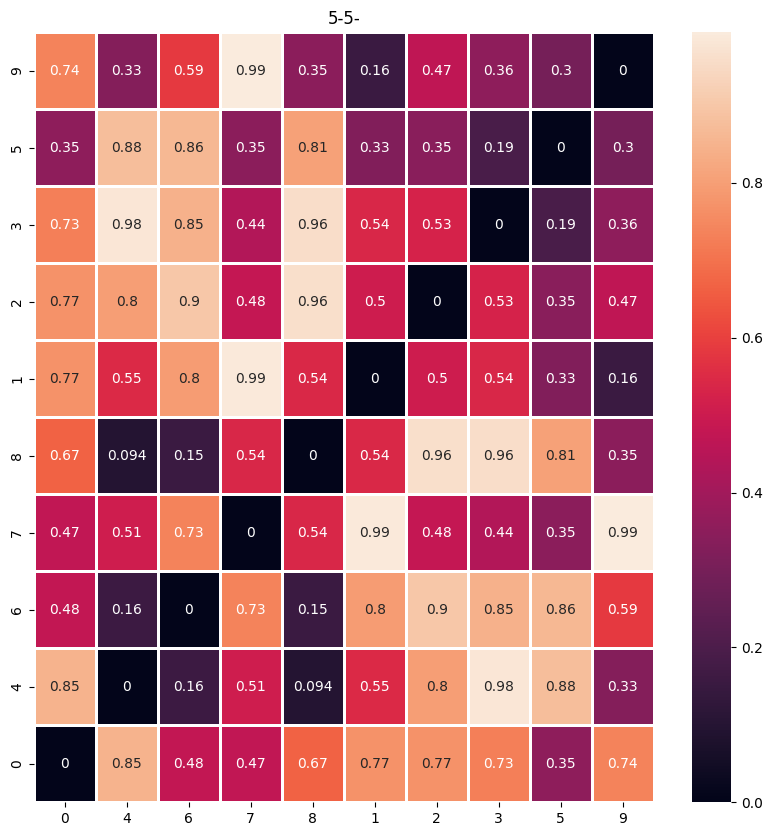

In [32]:
from sklearn.datasets import make_classification
# we will consider a data set with 15 features: 7 informative, 3 redundant, and 2: repeated
# shuffle is set to False to detect the preprocessing results
X1, y = make_classification(n_samples=4000, n_features = 15,n_informative=5, n_redundant=5, n_repeated=0, shuffle=False, random_state=11)

X1 = pd.DataFrame(data=X1, columns=range(X1.shape[1]))

pso = PsoMultiCol()

new_X1 = pso.eliminate_multicol(X1.copy())

In [33]:
# record = pso.pso.record_value
# xlist, vlist = record['X'], record['V']

# for x in xlist:
#     for y in x:
#         print(pso._get_clusters(y))

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=11)
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train1, y_train1)
y_pred1 = lr.predict(X_test1)
print(accuracy_score(y_test1, y_pred1))

0.675


In [35]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_X1,y,  test_size=0.2, random_state=11)
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train1, y_train1)
y_pred1 = lr.predict(X_test1)
print(accuracy_score(y_test1, y_pred1))

0.56625


In [36]:
# class MultiColPSO:
#     def __init__ (self, df:pd.DataFrame):
#         self.df = df
#         # calculate the spearmanr correlation of the dataframe's features
#         corr = spearmanr(df).correlation
#         # make sure it is symmetric
#         corr = (corr + corr.T) / 2
#         # fill the diagonal with 1s
#         np.fill_diagonal(corr, 1)
#         # transform the matrix to a dataframe that represents how similar each feature it is to another
#         self.dis_matrix = pd.DataFrame(data= (1 - np.abs (corr)), columns=list(df.columns), index=list(df.columns))
#         # have a dictionary mapping the column's order to its name
#         self.columns_dict = dict(list(zip(range(len(df.columns)), df.columns)))
#         # set the number of features for later reference
#         self.num_feats = len(df.columns)
#         # save the column names for later reference
#         self.columns = list(df.columns)
#         # a field to save the PSO object 
#         self.pso = None
        
#     def _get_vif(self):
#         vif = pd.DataFrame()
#         vif['VIF'] = [variance_inflation_factor(self.df.values, i) for i in range(len(self.df.columns))]
#         vif['variables'] = self.df.columns
#         return vif.set_index('variables')
        
#     def _number_clusters(self, particle: np.array):
#         particle_size = len(particle)
#         count = 0
#         # each consecutive num_feats elements represents one possible cluster
#         # the values should be converted to binary values with respect to 0.5
#         # a block of num_feats consecutive elemnts with at least one value larger than 0.5 represents a non-empty cluster
#         for i in range(0, particle_size, self.num_feats):
#             count += int((particle[i: i + self.num_feats] > 0.5).sum() > 0)
        
#         return count
        
#     def _feat_clusters(self, particle: np.array, i:int):
#         # check the number of clusters the i-th feature belongs to
#         particle_size = len(particle)
#         return  np.array([particle[x] > 0.5 for x in range(i, particle_size, self.num_feats)]).sum()

#     def _set_constraints(self, k1: int, k2: int):
#         # return list of the constraints that should be respected in the PSO solution
#         constraints = []
#         # first make sure the number of clusters is less than k2
#         constraints.append(lambda x: self._number_clusters(x) - k2)
#         # also make sure the number of clusters is larger than k1
#         constraints.append(lambda x: -self._number_clusters(x) + k1)
#         # make sure each features belongs at most to one cluster
#         feat_funcs = [(lambda x: self._feat_clusters(x, i) - 1)  for i in range(self.num_feats)]
#         # add these constraints to the final constraints variable
#         constraints.extend(feat_funcs)
#         return constraints
    
#     def _clusters_performance(self, cluster_feats: dict):
#         score = 0
#         cluster_count = 0
#         for _, feats in cluster_feats.items():
#             cluster_count = cluster_count + 1 if feats else cluster_count
#             # if the list is empty, it means the cluster is empty (no actual cluster)
#             if not feats: 
#                 continue
#             cluster_names = [self.columns_dict[i] for i in feats]
#             no_cluster_names = [n for n in self.columns if n not in cluster_names]
#             # how similar the features in the same cluster to one another
#             inner_score = np.nanmean((self.dis_matrix.loc[cluster_names, cluster_names] ** 2) / 2) 
#             # how dissimilar the features in the cluster to the features outside the cluster
#             outer_score = np.nanmean((self.dis_matrix.loc[cluster_names, no_cluster_names] ** 2) / 2)
#             score += (1 / (1 + inner_score) + outer_score) / 2     
        
#         # divide the score by the number of clusters 
#         return score / cluster_count
    
#     def _get_binary_particle(self, particle):
#         return np.array([int(x > 0.5) for x in particle])
    
#     def _get_clusters(self, binary_particle):
#         particle_size = len(binary_particle)
#         cluster_feats = {}
#         for i in range(0, particle_size, self.num_feats):
#             cluster_feats[i // self.num_feats] = [(j % self.num_feats) for j in range(i, i + self.num_feats) if binary_particle[j] == 1]
#         return cluster_feats
    
    
#     def _pso_function(self, particle: np.array):
#         return self._clusters_performance(self._get_clusters(self._get_binary_particle(particle)))
    
#     def _get_new_df(self, particle: np.array):
#         try:
#             iter(particle[0])
#             particle = particle[0]
#         except TypeError :
#             pass
                            
#         cluster_feats = self._get_clusters(self._get_binary_particle(particle))
        
#         # from each cluster keep only the first column
#         final_columns = [self.columns_dict[feats[0]] for feats in cluster_feats.values()]            
#         return self.df.loc[:, final_columns]

            
#     def eliminate_multi_col(self):
#         # first of all determine the possible values of the number of clusters
#         vif = self._get_vif()
#         # calculate the number of collinear columns 
#         collinear = (vif['VIF'] >= 2.5).sum() 
#         non_collinear = self.num_feats - collinear
                    
#         if collinear == 0:
#             return self.df
        
#         # the number of clusters would be between
#         k1 = non_collinear  
#         k2 = non_collinear + floor(collinear * 0.5) 
        
#         # define local function to pass to the pso object
#         pso_function = lambda x: self._pso_function(x)
#         particle_size = k2 * self.num_feats
#         # lower bound is a vector will all zeros
#         lower_bound = np.zeros(particle_size)
#         # upper bound is a vector with all ones
#         upper_bound = np.ones(particle_size)
    
#         # time to set the variables necessary to run PSO
#         self.pso = PSO(func=pso_function, n_dim = particle_size, pop=10, max_iter=100 ,lb=lower_bound, ub=upper_bound,
#                   constraint_ueq=self._set_constraints(k1, k2))
#         # set the record mode one
#         self.pso.record_mode = True
#         # run the PSO algorithm
#         self.pso.run()
        
#         return self._get_new_df(self.pso.gbest_x)
        